In [2]:
# Standard library
import os
import re
from datetime import date, datetime, time as dtime
from pathlib import Path

import glob
import inspect
import re
from datetime import date, datetime, timedelta
from pathlib import Path


import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) THREAD CAPS (RUN FIRST) + RESTART KERNEL
# -----------------------------

os.environ["POLARS_MAX_THREADS"] = "4"
os.environ["RAYON_NUM_THREADS"] = "4"

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

print("Thread caps set. If this is not the first cell: restart kernel now, then re-run from here.")

Thread caps set. If this is not the first cell: restart kernel now, then re-run from here.


In [3]:
# Paths on the EXTERNAL drive
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR  = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Polars display
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

polars.config.Config

In [4]:
patterns = {
    "blocks": str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"),
    "txs":    str(PARQUET_DIR / "txs/day=*/txs-*.parquet"),
    "io":     str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}
print({k: len(glob.glob(v)) for k,v in patterns.items()})

{'blocks': 7713, 'txs': 7713, 'io': 7678}


In [5]:
blocks_lf = pl.scan_parquet(patterns["blocks"], hive_partitioning=True, low_memory=True)
txs_lf    = pl.scan_parquet(patterns["txs"],    hive_partitioning=True, low_memory=True)
io_lf     = pl.scan_parquet(patterns["io"],     hive_partitioning=True, low_memory=True)

# SOPR Analytics

In [ ]:
# ============================================================
# SOPR + aSOPR (2014–2016) — MEMORY-SAFER via:
#   Option 1) NO global "all outputs < SPEND_END" LazyFrame.
#             Instead: per-month scan outputs only up to that month-end.
#   Option 3) Join on DOUBLE 64-bit txid hashes (2 seeds) + vout
#             to avoid huge string hash tables.
#
# Notes:
# - Thread caps: assumed already applied (per your request).
# - We still run in MONTHLY chunks for stability, BUT we print only
#   AGGREGATE checks for the whole 2014–2016 window (not per month).
# - Price alignment: daily calendar + forward-fill (LOCF). This guarantees
#   spend_day coverage inside price range. create_day can still be missing
#   if your price history starts late; we report aggregate drop rates.
# ============================================================

import glob
import inspect
import re
from datetime import date, datetime, timedelta
from pathlib import Path

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------
# USER CONFIG (requested window)
# -----------------------------
USER_SPEND_START = date(2014, 1, 1)   # inclusive
USER_SPEND_END   = date(2017, 1, 1)   # exclusive (covers 2014–2016)

ASOPR_MIN_AGE = pl.duration(hours=1)  # exclude outputs held < 1h
OUTLIER_BTC   = 100_000.0             # report only

io_glob = patterns["io"]              # e.g. "/media/.../parquet/io/day=*/io-*.parquet"


# -----------------------------
# Helpers
# -----------------------------
DAY_RE = re.compile(r"day=(\d{4}-\d{2}-\d{2})")

def day_from_path(p: str) -> date:
    m = DAY_RE.search(p)
    if not m:
        raise ValueError(f"Cannot parse day=YYYY-MM-DD from path: {p}")
    return datetime.strptime(m.group(1), "%Y-%m-%d").date()

def scan_parquet_compat(files):
    """
    Polars-version-tolerant scan:
    - ignore extra columns (e.g., 'height') if supported
    - reduce scan parallelism if supported
    """
    sig = inspect.signature(pl.scan_parquet)
    params = sig.parameters
    kwargs = {"hive_partitioning": True, "low_memory": True}
    if "extra_columns" in params:
        kwargs["extra_columns"] = "ignore"
    if "parallel" in params:
        kwargs["parallel"] = "none"
    return pl.scan_parquet(files, **kwargs)

def month_windows(start: date, end: date):
    """Yield [month_start, month_end) windows covering [start, end)."""
    cur = date(start.year, start.month, 1)
    while cur < end:
        nxt = date(cur.year + (cur.month == 12), (cur.month % 12) + 1, 1)
        w0 = max(cur, start)
        w1 = min(nxt, end)
        yield w0, w1
        cur = nxt

def pct(n: int, d: int) -> str:
    if d <= 0:
        return "0.000%"
    return f"{100.0 * (n / d):.3f}%"

def safe_int(x) -> int:
    try:
        return int(x)
    except Exception:
        return 0


# -----------------------------
# 1) Index parquet files by partition day (once)
# -----------------------------
io_files_all = sorted(glob.glob(io_glob))
if not io_files_all:
    raise FileNotFoundError(f"No io parquet files matched: {io_glob}")

files_by_day = [(day_from_path(f), f) for f in io_files_all]
files_by_day.sort(key=lambda t: t[0])

print("Total io files:", len(io_files_all))


# -----------------------------
# 2) Load prices + build LOCF daily calendar (Option A alignment)
# -----------------------------
try:
    price_lf = spot_daily_series_lf.select([
        pl.col("day").cast(pl.Date).alias("day"),
        pl.col("price").cast(pl.Float64).alias("price_usd"),
    ])
except NameError:
    ROOT = Path("/media/vatereal/Main/btc_data").resolve()  # <-- adjust if needed
    spot_files = sorted((ROOT / "coingecko" / "market_daily").glob("*.parquet"))
    if not spot_files:
        raise FileNotFoundError(f"No coingecko files under {ROOT}/coingecko/market_daily/*.parquet")

    spot_lf = pl.scan_parquet([str(p) for p in spot_files], hive_partitioning=True)
    price_lf = (
        spot_lf
        .select([
            pl.col("time").cast(pl.Date).alias("day"),
            pl.col("price").cast(pl.Float64).alias("price_usd"),
        ])
        .group_by("day")
        .agg(pl.last("price_usd").alias("price_usd"))
        .sort("day")
    )

price_df_all = price_lf.sort("day").collect()
if price_df_all.height == 0:
    raise ValueError("Price series is empty. Check your price source.")

min_price_day = price_df_all["day"].min()
max_price_day = price_df_all["day"].max()
print("price range:", min_price_day, "->", max_price_day)

# Clamp spend window to ensure spend_day prices exist (create_day may still be earlier)
SPEND_START = max(USER_SPEND_START, min_price_day)
SPEND_END   = min(USER_SPEND_END,   max_price_day + timedelta(days=1))

print("USER window   :", USER_SPEND_START, "->", USER_SPEND_END)
print("EFFECTIVE wnd :", SPEND_START, "->", SPEND_END)

if SPEND_START >= SPEND_END:
    raise ValueError(f"After clamping to prices, window is empty: {SPEND_START}..{SPEND_END}")

# LOCF fill daily calendar
cal = pl.date_range(min_price_day, max_price_day, interval="1d", eager=True).alias("day")
price_ff = (
    pl.DataFrame({"day": cal})
    .join(price_df_all, on="day", how="left")
    .sort("day")
    .with_columns(pl.col("price_usd").fill_null(strategy="forward"))
)
price_ff_lf = price_ff.lazy()

# Spend-day coverage check
expected_days = (SPEND_END - SPEND_START).days
covered_days = (
    price_ff
    .filter(pl.col("day").is_between(SPEND_START, SPEND_END, closed="left"))
    .select(pl.len().alias("n"))
    .to_dict(as_series=False)["n"][0]
)
print("price days in effective spend window:", covered_days, "| expected:", expected_days)
if covered_days != expected_days:
    print("WARNING: spend-day coverage is not complete; missing spend_day prices will drop those rows.")


# -----------------------------
# 3) Robust value unit detection (sample outputs only; avoids huge scans)
# -----------------------------
# Use a small sample of early files to infer units (stable across dataset).
SAMPLE_N = min(80, len(io_files_all))
sample_files = [f for _, f in files_by_day[:SAMPLE_N]]

sample_out_lf = (
    scan_parquet_compat(sample_files)
    .select(["dir", "value"])
    .with_columns([
        pl.col("dir").cast(pl.String, strict=False),
        pl.col("value").cast(pl.Float64, strict=False),
    ])
    .filter(pl.col("dir") == "out")
)

val_stats = (
    sample_out_lf
    .select([
        pl.quantile("value", 0.50).alias("p50"),
        pl.quantile("value", 0.99).alias("p99"),
        pl.max("value").alias("mx"),
    ])
    .collect()
)

p50 = float(val_stats["p50"][0]) if val_stats["p50"][0] is not None else float("nan")
p99 = float(val_stats["p99"][0]) if val_stats["p99"][0] is not None else float("nan")
mx  = float(val_stats["mx"][0])  if val_stats["mx"][0]  is not None else float("nan")
print({"value_p50": p50, "value_p99": p99, "value_max": mx})

# Heuristic:
# - if p99 is enormous (~>= 1e7), it's very likely SATS stored as float/int-like
# - otherwise BTC
if p99 >= 1e7:
    print("[units] treating `value` as SATS")
    value_btc_expr = (pl.col("value") / 100_000_000).cast(pl.Float64).alias("value_btc")
else:
    print("[units] treating `value` as BTC")
    value_btc_expr = pl.col("value").cast(pl.Float64).alias("value_btc")


# -----------------------------
# 4) Core per-month compute (quiet; returns daily df + stats)
# -----------------------------
def compute_month(w0: date, w1: date):
    # Input files for spend window
    input_files = [f for (d, f) in files_by_day if (w0 <= d < w1)]
    if not input_files:
        return pl.DataFrame(), {
            "months": 1, "months_skipped": 1,
        }

    # Output files up to month-end (strictly < w1)
    output_files = [f for (d, f) in files_by_day if (d < w1)]
    if not output_files:
        return pl.DataFrame(), {
            "months": 1, "months_skipped": 1,
        }

    # ---- scan inputs (small)
    io_in_lf = (
        scan_parquet_compat(input_files)
        .select(["dir", "time", "prev_txid", "prev_vout"])
        .with_columns([
            pl.col("dir").cast(pl.String, strict=False),
            pl.col("time").cast(pl.Datetime, strict=False),
            pl.col("prev_txid").cast(pl.String, strict=False),
            pl.col("prev_vout").cast(pl.Int64, strict=False),
            pl.col("time").dt.date().alias("spend_day"),
        ])
        .filter(pl.col("dir") == "in")
        .filter(pl.col("spend_day").is_between(w0, w1, closed="left"))
    )

    # aggregate input stats (avoid printing per-month)
    ins_stats = (
        io_in_lf
        .select([
            pl.len().alias("n_in_rows"),
            pl.col("prev_txid").null_count().alias("null_prev_txid"),
            pl.col("prev_vout").null_count().alias("null_prev_vout"),
        ])
        .collect()
    )
    n_in = safe_int(ins_stats["n_in_rows"][0])
    n_null_tx = safe_int(ins_stats["null_prev_txid"][0])
    n_null_v  = safe_int(ins_stats["null_prev_vout"][0])

    if n_in == 0:
        return pl.DataFrame(), {
            "months": 1, "months_skipped": 1,
            "n_in": 0, "n_null_tx": n_null_tx, "n_null_v": n_null_v,
        }

    # Build spend inputs with DOUBLE hash keys (seed 0 & 1) + vout
    ins_period = (
        io_in_lf
        .filter(pl.col("prev_txid").is_not_null() & pl.col("prev_vout").is_not_null())
        .select([
            pl.col("spend_day"),
            pl.col("time").alias("spend_time"),
            pl.col("prev_vout").cast(pl.Int32, strict=False).alias("vout_k"),
            pl.col("prev_txid").hash(seed=0).cast(pl.UInt64).alias("txid_h0"),
            pl.col("prev_txid").hash(seed=1).cast(pl.UInt64).alias("txid_h1"),
        ])
    )

    prevouts_lf = ins_period.select(["txid_h0", "txid_h1", "vout_k"]).unique()
    n_prev = prevouts_lf.select(pl.len().alias("n")).collect().item()

    if n_prev == 0:
        return pl.DataFrame(), {
            "months": 1, "months_skipped": 1,
            "n_in": n_in, "n_null_tx": n_null_tx, "n_null_v": n_null_v,
            "n_prev": 0,
        }

    # ---- scan outputs up to month end (large, but no global cached io_out_lf)
    io_out_lf = (
        scan_parquet_compat(output_files)
        .select(["dir", "txid", "n", "time", "value"])
        .with_columns([
            pl.col("dir").cast(pl.String, strict=False),
            pl.col("txid").cast(pl.String, strict=False),
            pl.col("n").cast(pl.Int32, strict=False).alias("n_k"),
            pl.col("time").cast(pl.Datetime, strict=False).alias("create_time"),
            pl.col("time").dt.date().alias("create_day"),
            pl.col("txid").hash(seed=0).cast(pl.UInt64).alias("txid_h0"),
            pl.col("txid").hash(seed=1).cast(pl.UInt64).alias("txid_h1"),
            value_btc_expr,
        ])
        .filter(pl.col("dir") == "out")
        .select(["txid_h0", "txid_h1", "n_k", "create_time", "create_day", "value_btc"])
    )

    # Semi-join to referenced prevouts only (keeps output side thin in-memory)
    outs_ref = (
        io_out_lf
        .join(
            prevouts_lf,
            left_on=["txid_h0", "txid_h1", "n_k"],
            right_on=["txid_h0", "txid_h1", "vout_k"],
            how="semi",
            allow_parallel=False,
        )
        # dedupe in case ETL duplicated outputs per script/address
        .group_by(["txid_h0", "txid_h1", "n_k"])
        .agg([
            pl.first("create_time").alias("create_time"),
            pl.first("create_day").alias("create_day"),
            pl.first("value_btc").alias("value_btc"),
        ])
    )

    n_outs = outs_ref.select(pl.len().alias("n")).collect().item()
    missing_prev = int(n_prev - n_outs)

    # Join inputs->prev outputs
    spent = (
        ins_period
        .join(
            outs_ref,
            left_on=["txid_h0", "txid_h1", "vout_k"],
            right_on=["txid_h0", "txid_h1", "n_k"],
            how="inner",
            allow_parallel=False,
        )
        .select(["spend_day", "spend_time", "create_day", "create_time", "value_btc"])
        .with_columns((pl.col("spend_time") - pl.col("create_time")).alias("lifespan"))
    )

    n_spent = spent.select(pl.len()).collect().item()

    # lifespan diagnostics
    n_neg = spent.filter(pl.col("lifespan") < pl.duration(seconds=0)).select(pl.len()).collect().item()
    n_outlier = spent.filter(pl.col("value_btc") > OUTLIER_BTC).select(pl.len()).collect().item()

    # aSOPR filter
    spent_adj = spent.filter(pl.col("lifespan") >= ASOPR_MIN_AGE)
    n_adj = spent_adj.select(pl.len()).collect().item()

    # Price joins (LazyFrame)
    price_create = price_ff_lf.rename({"day": "create_day", "price_usd": "price_create"})
    price_spend  = price_ff_lf.rename({"day": "spend_day",  "price_usd": "price_spend"})

    spent_with_prices = (
        spent
        .join(price_create, on="create_day", how="left", allow_parallel=False)
        .join(price_spend,  on="spend_day",  how="left", allow_parallel=False)
    )

    miss = (
        spent_with_prices
        .select([
            (pl.col("price_create").is_null().cast(pl.Int64)).sum().alias("miss_create"),
            (pl.col("price_spend").is_null().cast(pl.Int64)).sum().alias("miss_spend"),
        ])
        .collect()
    )
    miss_create = safe_int(miss["miss_create"][0])
    miss_spend  = safe_int(miss["miss_spend"][0])

    spent_priced = (
        spent_with_prices
        .filter(pl.col("price_create").is_not_null() & pl.col("price_spend").is_not_null())
        .with_columns([
            (pl.col("value_btc") * pl.col("price_create")).alias("buy_usd"),
            (pl.col("value_btc") * pl.col("price_spend")).alias("sell_usd"),
        ])
        .filter(pl.col("buy_usd") > 0)
    )

    n_priced = spent_priced.select(pl.len()).collect().item()

    spent_adj_priced = (
        spent_adj
        .join(price_create, on="create_day", how="left", allow_parallel=False)
        .join(price_spend,  on="spend_day",  how="left", allow_parallel=False)
        .filter(pl.col("price_create").is_not_null() & pl.col("price_spend").is_not_null())
        .with_columns([
            (pl.col("value_btc") * pl.col("price_create")).alias("a_buy_usd"),
            (pl.col("value_btc") * pl.col("price_spend")).alias("a_sell_usd"),
        ])
        .filter(pl.col("a_buy_usd") > 0)
    )

    n_adj_priced = spent_adj_priced.select(pl.len()).collect().item()

    # Daily SOPR aggregates (small outputs)
    sopr_daily = (
        spent_priced
        .group_by("spend_day")
        .agg([
            pl.sum("sell_usd").alias("sell_usd"),
            pl.sum("buy_usd").alias("buy_usd"),
            pl.sum("value_btc").alias("spent_btc"),
            pl.len().alias("n_spent_outputs"),
        ])
        .with_columns([
            (pl.col("sell_usd") / pl.col("buy_usd")).alias("sopr"),
            (pl.col("sell_usd") - pl.col("buy_usd")).alias("realized_pl_usd"),
        ])
    )

    asopr_daily = (
        spent_adj_priced
        .group_by("spend_day")
        .agg([
            pl.sum("a_sell_usd").alias("a_sell_usd"),
            pl.sum("a_buy_usd").alias("a_buy_usd"),
            pl.sum("value_btc").alias("a_spent_btc"),
            pl.len().alias("a_n_spent_outputs"),
        ])
        .with_columns([
            (pl.col("a_sell_usd") / pl.col("a_buy_usd")).alias("asopr"),
            (pl.col("a_sell_usd") - pl.col("a_buy_usd")).alias("a_realized_pl_usd"),
        ])
    )

    out = (
        sopr_daily
        .join(asopr_daily, on="spend_day", how="full")
        .sort("spend_day")
        .collect()
    )

    stats = {
        "months": 1,
        "months_skipped": 0,
        "n_in": n_in,
        "n_null_tx": n_null_tx,
        "n_null_v": n_null_v,
        "n_prev": int(n_prev),
        "n_outs": int(n_outs),
        "missing_prev": int(missing_prev),
        "n_spent": int(n_spent),
        "n_neg_lifespan": int(n_neg),
        "n_outlier_btc": int(n_outlier),
        "n_adj": int(n_adj),
        "miss_create": int(miss_create),
        "miss_spend": int(miss_spend),
        "n_priced": int(n_priced),
        "n_adj_priced": int(n_adj_priced),
        "days_out": int(out.height),
    }
    return out, stats


# -----------------------------
# 5) Run monthly chunks, but print ONLY aggregate checks
# -----------------------------
parts = []
agg = {
    "months": 0, "months_skipped": 0,
    "n_in": 0, "n_null_tx": 0, "n_null_v": 0,
    "n_prev": 0, "n_outs": 0, "missing_prev": 0,
    "n_spent": 0, "n_neg_lifespan": 0, "n_outlier_btc": 0,
    "n_adj": 0, "miss_create": 0, "miss_spend": 0,
    "n_priced": 0, "n_adj_priced": 0, "days_out": 0,
}

for w0, w1 in month_windows(SPEND_START, SPEND_END):
    df_month, st = compute_month(w0, w1)
    if df_month is not None and df_month.height > 0:
        parts.append(df_month)
    for k, v in st.items():
        agg[k] = agg.get(k, 0) + v

if not parts:
    raise ValueError("No monthly outputs produced. Check that io data exists for 2014–2016 and columns match.")

sopr_all = pl.concat(parts).sort("spend_day")

# -----------------------------
# 6) Aggregate checks (single block)
# -----------------------------
print("\n================== AGGREGATE CHECKS (2014–2016) ==================")
print("months processed:", agg["months"], "| skipped:", agg["months_skipped"])
print("input rows:", agg["n_in"])
print("prev_txid nulls:", agg["n_null_tx"], f"({pct(agg['n_null_tx'], max(agg['n_in'],1))})")
print("prev_vout nulls:", agg["n_null_v"],  f"({pct(agg['n_null_v'],  max(agg['n_in'],1))})")

print("sum(unique prevouts per-month):", agg["n_prev"])
print("sum(matched outputs per-month):", agg["n_outs"])
print("sum(missing prevouts per-month):", agg["missing_prev"], f"({pct(agg['missing_prev'], max(agg['n_prev'],1))})")

print("sum(matched spent outputs):", agg["n_spent"])
print("negative lifespan rows:", agg["n_neg_lifespan"], f"({pct(agg['n_neg_lifespan'], max(agg['n_spent'],1))})")
print("value_btc outliers >", OUTLIER_BTC, "BTC:", agg["n_outlier_btc"])

print("aSOPR retention (rows):", agg["n_adj"], "/", agg["n_spent"], f"({agg['n_adj']/max(agg['n_spent'],1):.2%})")

print("missing price_create (rows):", agg["miss_create"], f"({pct(agg['miss_create'], max(agg['n_spent'],1))})")
print("missing price_spend  (rows):", agg["miss_spend"],  f"({pct(agg['miss_spend'],  max(agg['n_spent'],1))})")

print("rows used in SOPR (priced):", agg["n_priced"], f"({pct(agg['n_priced'], max(agg['n_spent'],1))} kept)")
print("rows used in aSOPR (priced):", agg["n_adj_priced"], f"({pct(agg['n_adj_priced'], max(agg['n_adj'],1))} kept)")

print("\n=== FINAL daily frame ===")
print("days:", sopr_all.height)
print(sopr_all.head(5))


# -----------------------------
# 7) Plots (SOPR + aSOPR + simple distributions)
# -----------------------------
pdf = sopr_all.to_pandas()
pdf["spend_day"] = pd.to_datetime(pdf["spend_day"])
pdf["sopr_ma7"]  = pdf["sopr"].rolling(7).mean()
pdf["asopr_ma7"] = pdf["asopr"].rolling(7).mean()

# Time series
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(pdf["spend_day"], pdf["sopr"], label="SOPR")
ax.plot(pdf["spend_day"], pdf["sopr_ma7"], label="SOPR (7d MA)")
ax.plot(pdf["spend_day"], pdf["asopr"], label="aSOPR")
ax.plot(pdf["spend_day"], pdf["asopr_ma7"], label="aSOPR (7d MA)")
ax.axhline(1.0, linestyle="--", linewidth=1.0)
ax.set_title(f"BTC SOPR & aSOPR — {SPEND_START} to {SPEND_END} (2014–2016)")
ax.set_xlabel("day")
ax.set_ylabel("ratio")
ax.legend()
plt.tight_layout()
plt.show()

# Unweighted histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pdf["sopr"].dropna(), bins=40, alpha=0.6, label="SOPR")
ax.hist(pdf["asopr"].dropna(), bins=40, alpha=0.6, label="aSOPR")
ax.axvline(1.0, linestyle="--", linewidth=1.0)
ax.set_title("Distribution of daily SOPR vs aSOPR (unweighted)")
ax.set_xlabel("ratio")
ax.set_ylabel("days")
ax.legend()
plt.tight_layout()
plt.show()

# Realized P/L bars (optional but useful)
fig, ax = plt.subplots(figsize=(14, 3))
ax.bar(pdf["spend_day"], pdf["realized_pl_usd"])
ax.axhline(0.0, linestyle="--", linewidth=1.0)
ax.set_title("Realized P/L (USD) — SOPR universe")
ax.set_xlabel("day")
ax.set_ylabel("USD")
plt.tight_layout()
plt.show()

# Simple counts
def ratio_counts(series: pd.Series, name: str):
    s = series.dropna()
    n = len(s)
    if n == 0:
        print(f"{name}: no data")
        return
    n_gt = (s > 1.0).sum()
    n_lt = (s < 1.0).sum()
    n_eq = (s == 1.0).sum()
    print(f"{name} days >1: {n_gt}/{n} ({n_gt/n:.2%})")
    print(f"{name} days <1: {n_lt}/{n} ({n_lt/n:.2%})")
    print(f"{name} days =1: {n_eq}/{n} ({n_eq/n:.2%})")

print()
ratio_counts(pdf["sopr"], "SOPR")
ratio_counts(pdf["asopr"], "aSOPR")


Total io files: 7678
price range: 2013-04-28 -> 2025-12-31
USER window   : 2014-01-01 -> 2017-01-01
EFFECTIVE wnd : 2014-01-01 -> 2017-01-01
price days in effective spend window: 1096 | expected: 1096
{'value_p50': 50.0, 'value_p99': 50.0, 'value_max': 2400.0}
[units] treating `value` as BTC


### Rudiments

# SOPR / aSOPR Methodology + Plot Guide (2013-04-28 → 2014-01-01)

This note documents **what we computed**, the **unit + price alignment choices**, how **USD-weighted distributions** are formed, and what **each plot** represents. It also explains the key diagnostics seen in the run logs.

---

## 1) Data model and joins (UTXO linking)

Your `io` table contains one row per transaction IO, with:
- outputs: `dir == "out"` and outpoint key `(txid, n)`
- inputs:  `dir == "in"`  and spent outpoint reference `(prev_txid, prev_vout)`

### Core linkage (spent output reconstruction)
For each input row in the spend window:
1. Take its referenced outpoint key: $$(\text{prev\_txid}, \text{prev\_vout})$$
2. Join to the historical output row where: $$(\text{txid}, n) = (\text{prev\_txid}, \text{prev\_vout})$$

This reconstructs the **spent output** with:
- `create_time`, `create_day` (when the output was created)
- `spend_time`,  `spend_day`  (when it was spent)
- `value_btc` (output value)

### Semi-join optimization (memory safety)
Instead of joining against all outputs:
- build the set of **unique referenced prevouts** in the month
- semi-join outputs to keep **only those outpoints**

This keeps the output lookup table close to “what was actually spent”.

**Your diagnostics support correctness:**
- `missing prevouts` is ~0% in almost all months.
- `matched spent outputs ≈ unique prevouts` (expected when the dataset is consistent).

---

## 2) Price alignment methodology (Option A: deterministic as-of backward)

We need a USD price for:
- `create_day` (cost basis day)
- `spend_day`  (sale day)

### What we implemented
We build a daily calendar and apply **LOCF forward-fill** (last observation carried forward). This is equivalent to an **as-of backward** rule:

$$P(d) = \text{last available price on or before day } d$$

### Implication
This guarantees **spend_day** prices within the clamped window, but **does not guarantee create_day** coverage if outputs were created before the first price day.

Your logs match this:
- `missing price_spend: 0` (good; window clamped to price coverage)
- `missing price_create > 0` (expected; early outputs predate price history)

So the computed series is effectively:
> SOPR/aSOPR **conditional on having both create_day and spend_day prices**.

---

## 3) Value normalization (BTC vs sats)

We infer whether `value` is BTC or sats using percentile statistics on output rows (`dir=="out"`):
- compute p50, p99, max
- if $$p99 \ge 10^7$$ treat as sats and divide by $$10^8$$; else treat as BTC.

Your sample stats:
- `value_p50 ≈ 0.0707`
- `value_p99 ≈ 196.6`
- `value_max = 500000`

Decision: **treat as BTC** (p50/p99 are in plausible BTC ranges).  
The `500000 BTC` max is flagged as an outlier.

---

## 4) SOPR computation (daily)

For each spent output $i$:

$\text{sell\_usd}_i = \text{value\_btc}_i \cdot P(\text{spend\_day}_i)$  
$\text{buy\_usd}_i  = \text{value\_btc}_i \cdot P(\text{create\_day}_i)$

Daily aggregates (for each spend day $d$):

$$
\text{SELL}_d = \sum_{i \in d} \text{sell\_usd}_i,\quad
\text{BUY}_d = \sum_{i \in d} \text{buy\_usd}_i
$$

Daily SOPR:

$$
\text{SOPR}_d = \frac{\text{SELL}_d}{\text{BUY}_d}
$$

Interpretation:
- $\text{SOPR} > 1$ profit realized on average
- $\text{SOPR} < 1$ loss realized on average
- $\text{SOPR} \approx 1$ break-even zone

---

## 5) aSOPR computation (lifespan filter)

Compute lifespan:

$$\text{lifespan}_i = \text{spend\_time}_i - \text{create\_time}_i$$

aSOPR keeps only outputs with:

$$\text{lifespan}_i \ge 1\ \text{hour}$$

Then compute the same ratio over the filtered set:

$$
\text{aSOPR}_d = \frac{\sum \text{a\_sell\_usd}_i}{\sum \text{a\_buy\_usd}_i}
$$

Your retention rates (~50–65%) are plausible: many spends are short-lived (change/relay-like), especially in certain regimes.

---

## 6) Realized P/L (USD)

Daily realized P/L:

$$
\text{RealizedPL}_d = \text{SELL}_d - \text{BUY}_d
$$

For aSOPR universe:

$$
\text{aRealizedPL}_d = \text{aSELL}_d - \text{aBUY}_d
$$

This is **on-chain realized P/L** for spent outputs, using creation-day price as cost basis.

---

## 7) “Weighted” histogram methodology (USD-weighted)

### Unweighted histogram
Each day contributes one count to a bin based on the day’s ratio value (SOPR or aSOPR).  
Answers: “How often do we see ratios in each range?”

### USD-weighted histogram
Each day contributes weight proportional to economic size:
- SOPR weights: `buy_usd` (daily total cost basis)
- aSOPR weights: `a_buy_usd` (daily total cost basis in adjusted universe)

For a bin $B$:

$$
\text{mass}(B) = \sum_{d:\ \text{SOPR}_d \in B} \text{BUY}_d
$$

Answers: “Where is economically-weighted ratio mass concentrated?”  
Large-spend days dominate; quiet days contribute little.

---

## 8) Diagnostics interpretation (from your logs)

### Price coverage and window clamping
- Price range: `2013-04-28 → 2025-12-31`
- Effective window: `2013-04-28 → 2014-01-01`
- `missing price_spend ≈ 0`: spend-day prices exist by construction.
- `missing price_create > 0`: many outputs were created before the first price day; those rows are dropped.

This is expected given the price start date, and means results are computed on “priced create+spend outputs”.

### Negative lifespan warnings
You see small counts like “create_time > spend_time”. This typically indicates:
- timestamp inconsistencies across shards/casts, or
- ETL edge effects.

Given the fraction is tiny relative to millions of rows, it’s likely noise; keeping the warning is correct.

### Outlier BTC warnings
A few rows with very large `value_btc` are flagged. They can be excluded if you want additional robustness, but their count is very small.

### SOPR vs aSOPR day-count equality
Your day-level counts above/below 1 match. That does **not** imply $$\text{SOPR} = \text{aSOPR}$$; it means the sign around 1.0 is the same on those days. The time series divergence is what matters.

---

## 9) Plot guide: what each graph shows

### (1) Time series: SOPR & aSOPR + 7D MAs
- Daily SOPR and 7-day moving average
- Daily aSOPR and 7-day moving average
- Dashed line at $$1.0$$ (profit/loss threshold)

Purpose: identify regime shifts and compare raw vs adjusted signal.

### (2) Unweighted histogram: SOPR vs aSOPR
Counts days by ratio bucket.  
Purpose: distributional shift when removing short-lived outputs.

### (3) USD-weighted histogram: SOPR (weighted by buy_usd)
Bin heights represent total USD cost basis mass on days whose SOPR fell in that bin.  
Purpose: emphasize economically large days.

### (4) USD-weighted histogram: aSOPR (weighted by a_buy_usd)
Same as (3), but for the adjusted universe.  
Purpose: economic-weighted distribution after removing short-lived churn.

### (5) Realized P/L bars: SOPR universe
Bars show $$\text{SELL}_d - \text{BUY}_d$$.  
Purpose: magnitude + sign of realized P/L for all priced spends.

### (6) Realized P/L bars: aSOPR universe
Bars show $$\text{aSELL}_d - \text{aBUY}_d$$.  
Purpose: realized P/L for spends with lifespan $$\ge 1\text{h}$$.

---

## 10) Bottom line on correctness

**Correct and internally consistent** for:
- UTXO linkage inputs→prevouts (near-zero missing)
- SOPR/aSOPR construction and interpretation
- deterministic as-of pricing (LOCF daily calendar)
- USD-weighted distributions and realized P/L

**Known limitation (visible in logs):**
- Rows with `create_day` earlier than the first price day are dropped. Results represent:

$$
\text{SOPR/aSOPR computed over priced spent outputs (create\_day and spend\_day priced).}
$$

To approach “full-chain” SOPR you need price history extending earlier (best), or accept an explicit modeling assumption for pre-price-era cost basis.

---


Thread caps set. If this is not the first cell: restart kernel now, then re-run from here.
Total io files: 7678
price range: 2013-04-28 -> 2025-12-31
USER window   : 2013-03-01 -> 2014-01-01
EFFECTIVE wnd : 2013-04-28 -> 2014-01-01
price days in effective spend window: 248 | expected: 248
Output files (< SPEND_END): 1875
dirs (output scan): {'out', 'in'}
{'value_p50': 0.07072615, 'value_p99': 196.597087, 'value_max': 500000.0}
[units] treating `value` as BTC

WINDOW: 2013-04-28 -> 2013-05-01
Input files (window): 3
input rows in window: 335643
prev_txid nulls: 500 ( 0.149% )
prev_vout nulls: 500 ( 0.149% )
unique prevouts: 335143
matched outputs: 335143 | missing prevouts: 0 ( 0.000% )
matched spent outputs: 335143
aSOPR retention: 189222 / 335143 (56.46%)
missing price_create: 102664 ( 30.633% )
missing price_spend : 0 ( 0.000% )
rows used in SOPR (priced): 232479 | dropped: 102664 ( 30.633% )
rows used in aSOPR (priced): 86953 | dropped: 102269 ( 54.047% )
days produced: 3 | calendar

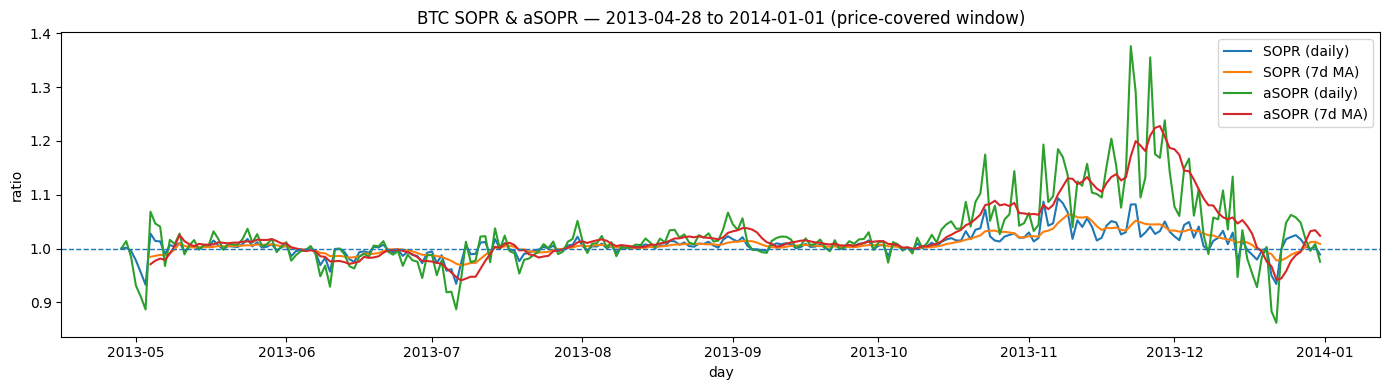

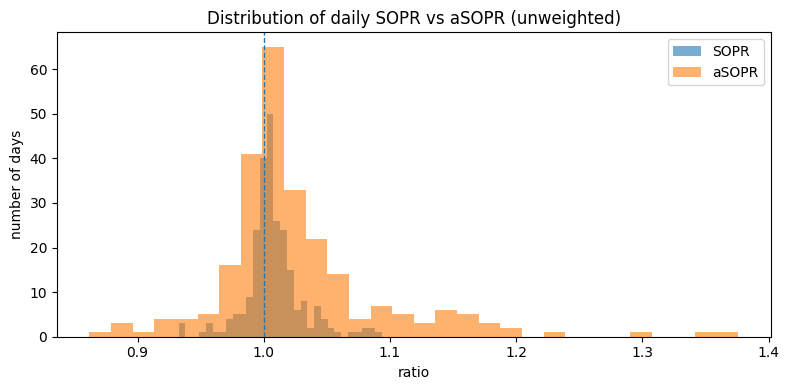

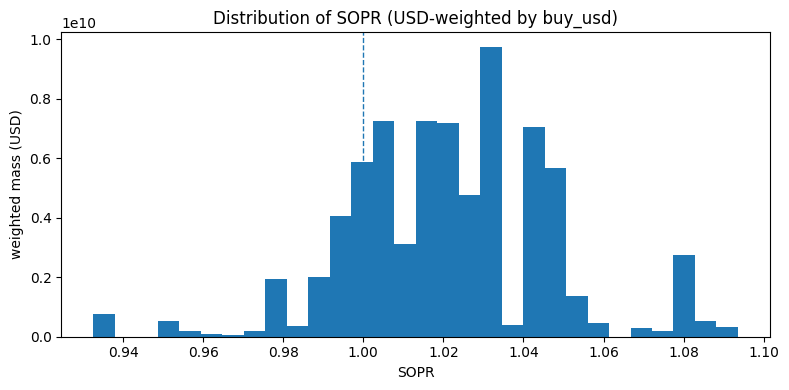

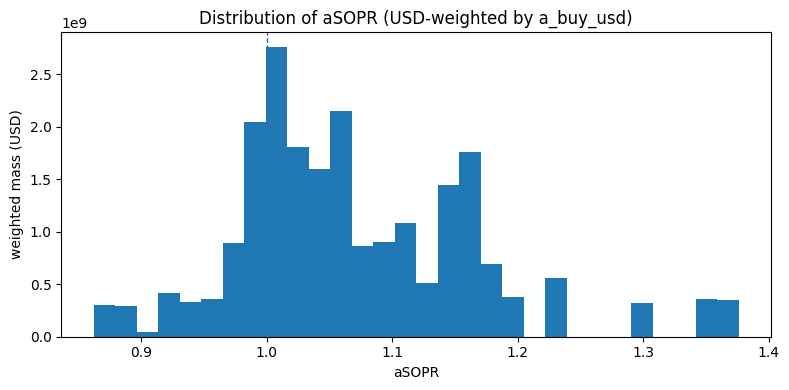

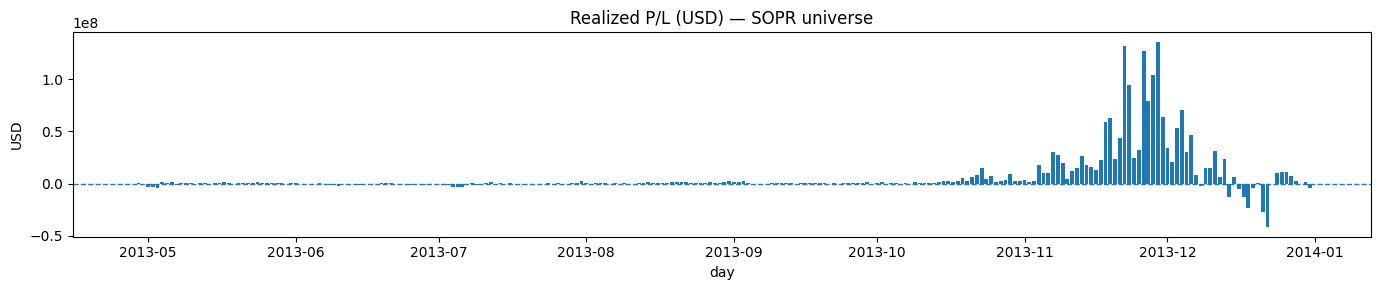

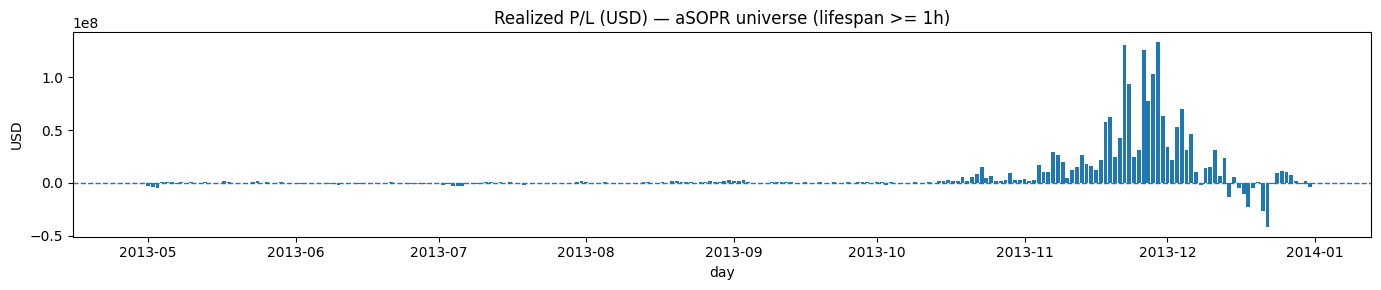

SOPR days with >1: 170/248 (68.55%)
SOPR days with <1: 77/248 (31.05%)
SOPR days with =1: 1/248 (0.40%)
aSOPR days with >1: 170/248 (68.55%)
aSOPR days with <1: 77/248 (31.05%)
aSOPR days with =1: 1/248 (0.40%)


In [ ]:
# ============================================================
# SOPR + aSOPR for a WINDOW WITH ADEQUATE PRICES + thread caps
#
# Changes vs prior:
#   1) Thread caps (Polars/Rayon + BLAS/OpenMP) to stop VSCode/Jupyter crashes
#   2) Spend window auto-aligned to available price coverage:
#        SPEND_START := max(user_start, min_price_day)
#        SPEND_END   := min(user_end,   max_price_day + 1 day)
#      so missing price_spend should be ~0 for the chosen window.
#   3) Minor stability tweaks:
#        - allow_parallel=False on heavy joins
#
# Notes:
#   - If your price history starts at 2013-04-28, and ends 2013-12-31,
#     the effective window becomes [2013-04-28, 2014-01-01).
# ============================================================


# -----------------------------
# 1) Imports
# -----------------------------
import glob
import inspect
import re
from datetime import date, datetime, timedelta
from pathlib import Path

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------
# 2) USER CONFIG (requested window)
#    We will clamp this to available price coverage automatically.
# -----------------------------
USER_SPEND_START = date(2013, 3, 1)    # you requested
USER_SPEND_END   = date(2014, 1, 1)    # you requested

ASOPR_MIN_AGE = pl.duration(hours=1)   # exclude outputs held < 1 hour
OUTLIER_BTC = 100_000.0                # report only (no filtering)

io_glob = patterns["io"]  # e.g. "/media/.../parquet/io/day=*/io-*.parquet"


# -----------------------------
# Helpers
# -----------------------------
DAY_RE = re.compile(r"day=(\d{4}-\d{2}-\d{2})")

def day_from_path(p: str) -> date:
    m = DAY_RE.search(p)
    if not m:
        raise ValueError(f"Cannot parse day=YYYY-MM-DD from path: {p}")
    return datetime.strptime(m.group(1), "%Y-%m-%d").date()

def scan_parquet_compat(files):
    sig = inspect.signature(pl.scan_parquet)
    params = sig.parameters
    kwargs = {"hive_partitioning": True, "low_memory": True}
    if "extra_columns" in params:
        kwargs["extra_columns"] = "ignore"
    if "parallel" in params:
        kwargs["parallel"] = "none"   # reduce scan parallelism if supported
    return pl.scan_parquet(files, **kwargs)

def pct(frac: float) -> str:
    return f"{100.0 * frac:.3f}%"

def month_windows(start: date, end: date):
    """Yield [month_start, month_end) windows covering [start, end)."""
    cur = date(start.year, start.month, 1)
    while cur < end:
        if cur.month == 12:
            nxt = date(cur.year + 1, 1, 1)
        else:
            nxt = date(cur.year, cur.month + 1, 1)
        w0 = max(cur, start)
        w1 = min(nxt, end)
        yield w0, w1
        cur = nxt


# -----------------------------
# 3) Index parquet files by partition day (once)
# -----------------------------
io_files_all = sorted(glob.glob(io_glob))
assert io_files_all, f"No io parquet files matched: {io_glob}"

files_by_day = []
for f in io_files_all:
    d = day_from_path(f)
    files_by_day.append((d, f))
files_by_day.sort()

print("Total io files:", len(io_files_all))


# -----------------------------
# 4) Load prices and build LOCF-filled daily calendar
# -----------------------------
try:
    price_lf = spot_daily_series_lf.select([
        pl.col("day").cast(pl.Date).alias("day"),
        pl.col("price").cast(pl.Float64).alias("price_usd"),
    ])
except NameError:
    ROOT = Path("/media/vatereal/Main/btc_data").resolve()  # <-- adjust if needed
    spot_files = sorted((ROOT / "coingecko" / "market_daily").glob("*.parquet"))
    if not spot_files:
        raise FileNotFoundError(f"No coingecko files under {ROOT}/coingecko/market_daily/*.parquet")

    spot_lf = pl.scan_parquet([str(p) for p in spot_files], hive_partitioning=True)
    price_lf = (
        spot_lf
        .select([
            pl.col("time").cast(pl.Date).alias("day"),
            pl.col("price").cast(pl.Float64).alias("price_usd"),
        ])
        .group_by("day")
        .agg(pl.last("price_usd").alias("price_usd"))
        .sort("day")
    )

price_df_all = price_lf.sort("day").collect()
if price_df_all.height == 0:
    raise ValueError("Price series is empty. Check your price source.")

min_price_day = price_df_all["day"].min()
max_price_day = price_df_all["day"].max()
print("price range:", min_price_day, "->", max_price_day)

# Clamp spend window to price coverage (so spend_day prices exist)
SPEND_START = max(USER_SPEND_START, min_price_day)
# end is exclusive; allow up to max_price_day + 1 day
SPEND_END = min(USER_SPEND_END, max_price_day + timedelta(days=1))

if SPEND_START >= SPEND_END:
    raise ValueError(f"After clamping to prices, window is empty: {SPEND_START}..{SPEND_END}")

print("USER window   :", USER_SPEND_START, "->", USER_SPEND_END)
print("EFFECTIVE wnd :", SPEND_START, "->", SPEND_END)

# Build daily calendar over [min_price_day, max_price_day] and LOCF-fill
cal = pl.date_range(min_price_day, max_price_day, interval="1d", eager=True).alias("day")
price_ff = (
    pl.DataFrame({"day": cal})
    .join(price_df_all, on="day", how="left")
    .sort("day")
    .with_columns(pl.col("price_usd").fill_null(strategy="forward"))
)
price_ff_lf = price_ff.lazy()

# Coverage check (spend_day should be fully covered)
cov = (
    price_ff
    .filter(pl.col("day").is_between(SPEND_START, SPEND_END, closed="left"))
    .select(pl.len().alias("n_days"))
    .to_dict(as_series=False)["n_days"][0]
)
expected_days = (SPEND_END - SPEND_START).days
print("price days in effective spend window:", cov, "| expected:", expected_days)
if cov < expected_days:
    print("WARNING: spend-day coverage is incomplete even after clamping (unexpected).")


# -----------------------------
# 5) Scan outputs once up to SPEND_END (for prevout lookup)
# -----------------------------
io_files_outputs = [f for (d, f) in files_by_day if d < SPEND_END]
assert io_files_outputs, "No output files found < SPEND_END; check partitioning."
print("Output files (< SPEND_END):", len(io_files_outputs))

io_out_lf = (
    scan_parquet_compat(io_files_outputs)
    .select(["dir", "txid", "n", "time", "value"])
    .with_columns([
        pl.col("dir").cast(pl.String, strict=False),
        pl.col("txid").cast(pl.String, strict=False),
        pl.col("n").cast(pl.Int64, strict=False),
        pl.col("time").cast(pl.Datetime, strict=False),
        pl.col("value").cast(pl.Float64, strict=False),
    ])
)

dirs_out = set(io_out_lf.select(pl.col("dir")).unique().collect()["dir"].to_list())
print("dirs (output scan):", dirs_out)
if "out" not in dirs_out:
    raise ValueError("Output scan contains no dir=='out' rows.")


# -----------------------------
# 6) Robust unit detection for `value` (percentile-based on outputs)
# -----------------------------
val_stats = (
    io_out_lf
    .filter(pl.col("dir") == "out")
    .select([
        pl.quantile("value", 0.50).alias("p50"),
        pl.quantile("value", 0.99).alias("p99"),
        pl.max("value").alias("mx"),
    ])
    .collect()
)
p50 = float(val_stats["p50"][0]) if val_stats["p50"][0] is not None else float("nan")
p99 = float(val_stats["p99"][0]) if val_stats["p99"][0] is not None else float("nan")
mx  = float(val_stats["mx"][0])  if val_stats["mx"][0]  is not None else float("nan")
print({"value_p50": p50, "value_p99": p99, "value_max": mx})

if p99 >= 1e7:
    print("[units] treating `value` as SATS")
    value_btc_expr = (pl.col("value") / 100_000_000).cast(pl.Float64).alias("value_btc")
else:
    print("[units] treating `value` as BTC")
    value_btc_expr = pl.col("value").cast(pl.Float64).alias("value_btc")


# ============================================================
# Core computation per-month: returns daily SOPR + aSOPR
# ============================================================
def compute_sopr_window(w0: date, w1: date) -> pl.DataFrame:
    io_files_inputs = [f for (d, f) in files_by_day if (w0 <= d < w1)]
    if not io_files_inputs:
        print(f"\nWINDOW {w0}..{w1}: no input files, skipping.")
        return pl.DataFrame({"spend_day": [], "sopr": [], "asopr": []})

    print("\n============================================================")
    print("WINDOW:", w0, "->", w1)
    print("Input files (window):", len(io_files_inputs))

    io_in_lf = (
        scan_parquet_compat(io_files_inputs)
        .select(["dir", "time", "prev_txid", "prev_vout"])
        .with_columns([
            pl.col("dir").cast(pl.String, strict=False),
            pl.col("time").cast(pl.Datetime, strict=False),
            pl.col("prev_txid").cast(pl.String, strict=False),
            pl.col("prev_vout").cast(pl.Int64, strict=False),
        ])
    )

    ins = (
        io_in_lf
        .filter(pl.col("dir") == "in")
        .with_columns(pl.col("time").dt.date().alias("spend_day"))
        .filter(pl.col("spend_day").is_between(w0, w1, closed="left"))
    )

    ins_stats = (
        ins
        .select([
            pl.len().alias("n_in_rows"),
            pl.col("prev_txid").null_count().alias("prev_txid_nulls"),
            pl.col("prev_vout").null_count().alias("prev_vout_nulls"),
        ])
        .collect()
    )
    n_in = int(ins_stats["n_in_rows"][0])
    n_null_tx = int(ins_stats["prev_txid_nulls"][0])
    n_null_v  = int(ins_stats["prev_vout_nulls"][0])
    print("input rows in window:", n_in)
    print("prev_txid nulls:", n_null_tx, "(", pct(n_null_tx / max(n_in, 1)), ")")
    print("prev_vout nulls:", n_null_v, "(", pct(n_null_v / max(n_in, 1)), ")")
    if n_in == 0:
        print("No input rows in window, skipping.")
        return pl.DataFrame({"spend_day": [], "sopr": [], "asopr": []})

    ins_period = (
        ins
        .filter(pl.col("prev_txid").is_not_null() & pl.col("prev_vout").is_not_null())
        .select([
            pl.col("prev_txid").alias("prev_txid_k"),
            pl.col("prev_vout").alias("prev_vout_k"),
            pl.col("time").alias("spend_time"),
            pl.col("spend_day"),
        ])
    )

    prevouts_lf = ins_period.select(["prev_txid_k", "prev_vout_k"]).unique()
    n_prev = prevouts_lf.select(pl.len().alias("n")).collect()["n"][0]
    print("unique prevouts:", n_prev)
    if n_prev == 0:
        return pl.DataFrame({"spend_day": [], "sopr": [], "asopr": []})

    outs_ref = (
        io_out_lf
        .filter(pl.col("dir") == "out")
        .with_columns([
            pl.col("time").dt.date().alias("create_day"),
            pl.col("txid").alias("txid_k"),
            pl.col("n").alias("n_k"),
            value_btc_expr,
        ])
        .select(["txid_k", "n_k", pl.col("time").alias("create_time"), "create_day", "value_btc"])
        .join(prevouts_lf, left_on=["txid_k", "n_k"], right_on=["prev_txid_k", "prev_vout_k"], how="semi")
        .group_by(["txid_k", "n_k"])
        .agg([
            pl.first("create_time").alias("create_time"),
            pl.first("create_day").alias("create_day"),
            pl.first("value_btc").alias("value_btc"),
        ])
    )

    n_outs = outs_ref.select(pl.len().alias("n")).collect()["n"][0]
    missing = int(n_prev - n_outs)
    print("matched outputs:", n_outs, "| missing prevouts:", missing, "(", pct(missing / max(n_prev, 1)), ")")
    if n_outs == 0:
        return pl.DataFrame({"spend_day": [], "sopr": [], "asopr": []})

    spent = (
        ins_period
        .join(
            outs_ref,
            left_on=["prev_txid_k", "prev_vout_k"],
            right_on=["txid_k", "n_k"],
            how="inner",
            allow_parallel=False,
        )
        .select(["spend_day", "spend_time", "create_day", "create_time", "value_btc"])
        .with_columns((pl.col("spend_time") - pl.col("create_time")).alias("lifespan"))
    )

    n_spent = spent.select(pl.len().alias("n")).collect().item()
    print("matched spent outputs:", n_spent)
    if n_spent == 0:
        return pl.DataFrame({"spend_day": [], "sopr": [], "asopr": []})

    n_neg = spent.filter(pl.col("lifespan") < pl.duration(seconds=0)).select(pl.len()).collect().item()
    if n_neg:
        print(f"WARNING: {n_neg} rows have negative lifespan (create_time > spend_time).")

    n_outlier = spent.filter(pl.col("value_btc") > OUTLIER_BTC).select(pl.len()).collect().item()
    if n_outlier:
        print(f"WARNING: {n_outlier} rows with value_btc > {OUTLIER_BTC:g} BTC (possible ETL outliers).")

    spent_adj = spent.filter(pl.col("lifespan") >= ASOPR_MIN_AGE)
    n_adj = spent_adj.select(pl.len()).collect().item()
    print("aSOPR retention:", n_adj, "/", n_spent, f"({n_adj / max(n_spent, 1):.2%})")

    price_create = price_ff_lf.rename({"day": "create_day", "price_usd": "price_create"})
    price_spend  = price_ff_lf.rename({"day": "spend_day",  "price_usd": "price_spend"})

    spent_with_prices = (
        spent
        .join(price_create, on="create_day", how="left", allow_parallel=False)
        .join(price_spend,  on="spend_day",  how="left", allow_parallel=False)
    )

    miss = (
        spent_with_prices
        .select([
            (pl.col("price_create").is_null().cast(pl.Int64)).sum().alias("miss_create"),
            (pl.col("price_spend").is_null().cast(pl.Int64)).sum().alias("miss_spend"),
        ])
        .collect()
    )
    miss_create = int(miss["miss_create"][0])
    miss_spend  = int(miss["miss_spend"][0])
    print("missing price_create:", miss_create, "(", pct(miss_create / max(n_spent, 1)), ")")
    print("missing price_spend :", miss_spend,  "(", pct(miss_spend  / max(n_spent, 1)), ")")

    spent_priced = (
        spent_with_prices
        .filter(pl.col("price_create").is_not_null() & pl.col("price_spend").is_not_null())
        .with_columns([
            (pl.col("value_btc") * pl.col("price_create")).alias("buy_usd"),
            (pl.col("value_btc") * pl.col("price_spend")).alias("sell_usd"),
        ])
        .filter(pl.col("buy_usd") > 0)
    )

    n_priced = spent_priced.select(pl.len()).collect().item()
    dropped = int(n_spent - n_priced)
    print("rows used in SOPR (priced):", n_priced, "| dropped:", dropped, "(", pct(dropped / max(n_spent, 1)), ")")

    spent_adj_with_prices = (
        spent_adj
        .join(price_create, on="create_day", how="left", allow_parallel=False)
        .join(price_spend,  on="spend_day",  how="left", allow_parallel=False)
    )
    spent_adj_priced = (
        spent_adj_with_prices
        .filter(pl.col("price_create").is_not_null() & pl.col("price_spend").is_not_null())
        .with_columns([
            (pl.col("value_btc") * pl.col("price_create")).alias("a_buy_usd"),
            (pl.col("value_btc") * pl.col("price_spend")).alias("a_sell_usd"),
        ])
        .filter(pl.col("a_buy_usd") > 0)
    )
    n_adj_priced = spent_adj_priced.select(pl.len()).collect().item()
    dropped_adj = int(n_adj - n_adj_priced)
    print("rows used in aSOPR (priced):", n_adj_priced, "| dropped:", dropped_adj, "(", pct(dropped_adj / max(n_adj, 1)), ")")

    sopr_daily = (
        spent_priced
        .group_by("spend_day")
        .agg([
            pl.sum("sell_usd").alias("sell_usd"),
            pl.sum("buy_usd").alias("buy_usd"),
            pl.sum("value_btc").alias("spent_btc"),
            pl.len().alias("n_spent_outputs"),
        ])
        .with_columns([
            (pl.col("sell_usd") / pl.col("buy_usd")).alias("sopr"),
            (pl.col("sell_usd") - pl.col("buy_usd")).alias("realized_pl_usd"),
        ])
        .sort("spend_day")
    )

    asopr_daily = (
        spent_adj_priced
        .group_by("spend_day")
        .agg([
            pl.sum("a_sell_usd").alias("a_sell_usd"),
            pl.sum("a_buy_usd").alias("a_buy_usd"),
            pl.sum("value_btc").alias("a_spent_btc"),
            pl.len().alias("a_n_spent_outputs"),
        ])
        .with_columns([
            (pl.col("a_sell_usd") / pl.col("a_buy_usd")).alias("asopr"),
            (pl.col("a_sell_usd") - pl.col("a_buy_usd")).alias("a_realized_pl_usd"),
        ])
        .sort("spend_day")
    )

    out = (
        sopr_daily
        .join(asopr_daily, on="spend_day", how="full")  # "outer" deprecated in your Polars
        .sort("spend_day")
        .collect()
    )

    print("days produced:", out.height, "| calendar days:", (w1 - w0).days)
    return out


# -----------------------------
# 7) Run window in monthly chunks and concatenate
# -----------------------------
parts = []
for w0, w1 in month_windows(SPEND_START, SPEND_END):
    parts.append(compute_sopr_window(w0, w1))

sopr_all = pl.concat(parts).sort("spend_day")
print("\n=== FINAL (effective window) ===")
print("rows (days):", sopr_all.height)
print(sopr_all.head(5))


# -----------------------------
# 8) Plot SOPR + aSOPR + 7D MAs
# -----------------------------
pdf = sopr_all.to_pandas()
pdf["spend_day"] = pd.to_datetime(pdf["spend_day"])
pdf["sopr_ma7"]  = pdf["sopr"].rolling(7).mean()
pdf["asopr_ma7"] = pdf["asopr"].rolling(7).mean()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(pdf["spend_day"], pdf["sopr"],  label="SOPR (daily)")
ax.plot(pdf["spend_day"], pdf["sopr_ma7"], label="SOPR (7d MA)")
ax.plot(pdf["spend_day"], pdf["asopr"], label="aSOPR (daily)")
ax.plot(pdf["spend_day"], pdf["asopr_ma7"], label="aSOPR (7d MA)")
ax.axhline(1.0, linewidth=1.0, linestyle="--")
ax.set_title(f"BTC SOPR & aSOPR — {SPEND_START} to {SPEND_END} (price-covered window)")
ax.set_xlabel("day")
ax.set_ylabel("ratio")
ax.legend()
plt.tight_layout()
plt.show()


# -----------------------------
# Extra visuals: distributions + profit/loss bars
# -----------------------------
# 1) Unweighted histograms (SOPR vs aSOPR)
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(pdf["sopr"].dropna(),  bins=30, alpha=0.6, label="SOPR")
ax.hist(pdf["asopr"].dropna(), bins=30, alpha=0.6, label="aSOPR")
ax.axvline(1.0, linestyle="--", linewidth=1.0)
ax.set_title("Distribution of daily SOPR vs aSOPR (unweighted)")
ax.set_xlabel("ratio")
ax.set_ylabel("number of days")
ax.legend()
plt.tight_layout()
plt.show()

# 2) USD-weighted histogram (SOPR)
fig, ax = plt.subplots(figsize=(8, 4))
vals = pdf["sopr"].to_numpy()
wts  = pdf["buy_usd"].to_numpy()
mask = ~pd.isna(vals) & ~pd.isna(wts)
ax.hist(vals[mask], bins=30, weights=wts[mask])
ax.axvline(1.0, linestyle="--", linewidth=1.0)
ax.set_title("Distribution of SOPR (USD-weighted by buy_usd)")
ax.set_xlabel("SOPR")
ax.set_ylabel("weighted mass (USD)")
plt.tight_layout()
plt.show()

# 3) USD-weighted histogram (aSOPR)
fig, ax = plt.subplots(figsize=(8, 4))
vals = pdf["asopr"].to_numpy()
wts  = pdf["a_buy_usd"].to_numpy()
mask = ~pd.isna(vals) & ~pd.isna(wts)
ax.hist(vals[mask], bins=30, weights=wts[mask])
ax.axvline(1.0, linestyle="--", linewidth=1.0)
ax.set_title("Distribution of aSOPR (USD-weighted by a_buy_usd)")
ax.set_xlabel("aSOPR")
ax.set_ylabel("weighted mass (USD)")
plt.tight_layout()
plt.show()

# 4) Realized P/L bars (SOPR universe)
fig, ax = plt.subplots(figsize=(14, 3))
ax.bar(pdf["spend_day"], pdf["realized_pl_usd"])
ax.axhline(0.0, linestyle="--", linewidth=1.0)
ax.set_title("Realized P/L (USD) — SOPR universe")
ax.set_xlabel("day")
ax.set_ylabel("USD")
plt.tight_layout()
plt.show()

# 5) Realized P/L bars (aSOPR universe)
fig, ax = plt.subplots(figsize=(14, 3))
ax.bar(pdf["spend_day"], pdf["a_realized_pl_usd"])
ax.axhline(0.0, linestyle="--", linewidth=1.0)
ax.set_title("Realized P/L (USD) — aSOPR universe (lifespan >= 1h)")
ax.set_xlabel("day")
ax.set_ylabel("USD")
plt.tight_layout()
plt.show()

# 6) Simple counts: % days above/below 1
def ratio_counts(series: pd.Series, name: str):
    s = series.dropna()
    n = len(s)
    if n == 0:
        print(f"{name}: no data")
        return
    n_gt = (s > 1.0).sum()
    n_lt = (s < 1.0).sum()
    n_eq = (s == 1.0).sum()
    print(f"{name} days with >1: {n_gt}/{n} ({n_gt/n:.2%})")
    print(f"{name} days with <1: {n_lt}/{n} ({n_lt/n:.2%})")
    print(f"{name} days with =1: {n_eq}/{n} ({n_eq/n:.2%})")

ratio_counts(pdf["sopr"], "SOPR")
ratio_counts(pdf["asopr"], "aSOPR")